# Neural Networks for Data Science Applications
## Second Homework: Experimenting with modularity in deep learning

**Name**: *Cosmin Madalin Zaharia*

**Matricola**: *1805207*

> ✍ Upload the completed notebook **at least two days prior** to the exam's date on Google Classroom. For example, for the January call (25/01/2023), the final deadline is **23/01/2023 at 23:59** (GMT+1).

**Overview**: The homework is composed of three parts: (i) selecting a dataset and training a standard neural network (<ins>4 points</ins>); (ii) implementing a modular architecture (either an early-exit model or a mixture-of-experts model) and testing it (<ins>6 points</ins>); (iii) implementing a load balancing regularization (ONLY if you did not upload the 1st homework or if you want to improve your mark, </ins>5 points</ins>).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: like for the first homework, this must be done fully in TensorFlow and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

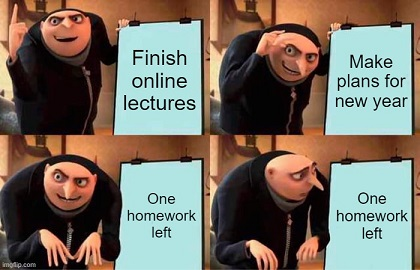

### Warm-up: Selecting a dataset

During the course, we were able to see only a small selection of datasets. For this homework, you are free to select any dataset that you believe interesting (images, audios, texts, graphs)...

A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. As a rule of thumb, the choice of dataset will not influence the mark (with few exceptions, see below), so you can select a complexity that you believe adequate to your skills.

🟩 **Please do:**

1. Provide a complete description of the dataset and the task below.
2. You are not limited to classification tasks. However, tasks that were not seen during the course (e.g., segmentation) **must be thoroughly explained in the text**.
3. Data preprocessing should be done as much as possible in `tf.data`.

🟥 **Please don't:**

1. Absolutely do not use datasets that were seen during our lab sessions.
2. Do not use MNIST, CIFAR-10, CIFAR-100, or any simple variation (e.g., Fashion MNIST).

-----------

**IMPORT THE DATASET**

In [ ]:
!pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 76 bytes


In [3]:
!kaggle datasets download -d gpiosenka/cards-image-datasetclassification

 96% 369M/385M [00:06<00:00, 17.2MB/s]
100% 385M/385M [00:06<00:00, 62.4MB/s]


In [4]:
'''
  If you want to download the dataset into a specific directory, change this path -> ./game-card
  /dev/null 2>&1 to avoid printing tùhe output.
'''
!unzip cards-image-datasetclassification.zip -d ./game-card > /dev/null 2>&1

I converted all the jpg images to jpeg because the tensorflow function (image_dataset_from_directory) doesn't accept jpg images.


In [5]:
from PIL import Image
import os

def convert_jpg_to_jpeg(directory):

    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith('.jpg'):
                filepath = os.path.join(dirpath, filename)
                with Image.open(filepath) as img:
                    new_filepath = os.path.join(dirpath, filename[:-4] + '.jpeg')
                    img.save(new_filepath, "JPEG")
                    os.remove(filepath)

directory = './game-card'
convert_jpg_to_jpeg(directory)
print("Conversion done!")

Conversion done!


----------

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

The dataset that I decide to use is [Card Classification](https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification), from Kaggle. It consist of 7624 training images, 265 test images and 265 validation images with 53 different categories (a 'normal' French deck, look at the joker card into the test set).
Each image is an rgb image and the particularity of these cards is that they are all very different from each other both in design and with respect to contrasts.

 the dataset is already divided in train, validation and test set, so for this reason I'll use 'tf.keras.utils.image_dataset_from_directory' without divided immediatly in batch because I want to apply some resizing and tf.data.AUTOTUNE (useful for the efficiency of the training process)

In [6]:
# All the utils
import time
import numpy as np
from tqdm import *
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, regularizers, losses, optimizers, metrics, callbacks

In [7]:
train_image_directory = './game-card/train'
val_image_directory = './game-card/valid'
test_image_directory = './game-card/test'

In [8]:
def get_the_datasets(train_image_directory, val_image_directory, test_image_directory,  size_w = 120,  size_h = 120, batchsize = None):

  train_ds = tf.keras.utils.image_dataset_from_directory(
    train_image_directory,
    image_size=(size_w , size_h),
    batch_size=batchsize
    )

  val_ds = tf.keras.utils.image_dataset_from_directory(
    val_image_directory,
    image_size=(size_w , size_h),
    batch_size=batchsize
    )

  test_ds = tf.keras.utils.image_dataset_from_directory(
    test_image_directory,
    image_size=(size_w , size_h),
    batch_size=batchsize
    )

  return train_ds, val_ds, test_ds


def resizing_images(x, y):
  return x / 255.0, y

def augment_dataset(x, y):
    x = tf.image.random_contrast(x, lower=0.5, upper=1.)
    x = layers.RandomZoom(.1, .1)(x)
    return x, y

In [9]:
train_ds, val_ds, test_ds = get_the_datasets(train_image_directory, val_image_directory, test_image_directory, batchsize = None)

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.


In [10]:
class_names = train_ds.class_names #to use in the next block

# Apply resizing and augmentation to the sets
train_ds = train_ds.map(resizing_images).shuffle(1000).batch(64).map(augment_dataset).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(resizing_images).batch(64).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(resizing_images).batch(64).prefetch(tf.data.AUTOTUNE)

Let's have a look to the dataset

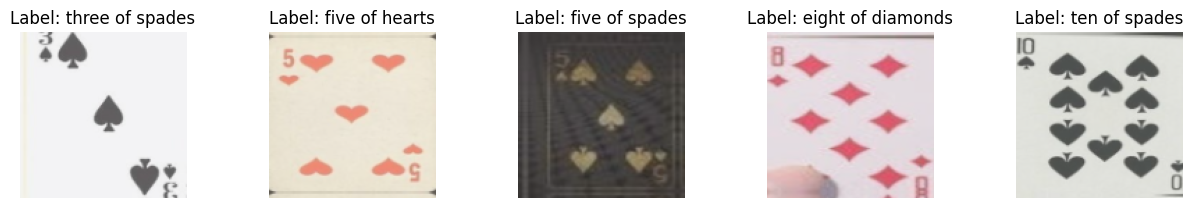

In [11]:
# Pick one batch from the training dataset
for images, labels in train_ds.take(1):

    random_indices = np.random.choice(64, size=5, replace=False) #random 5 images

    random_images = images.numpy()[random_indices]
    random_labels = labels.numpy()[random_indices]

    plt.figure(figsize=(15, 12))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(random_images[i])

        plt.title(f"Label: {class_names[random_labels[i]]}")

        plt.axis("off")

    plt.subplots_adjust(wspace=0.5)
    plt.show()

### Exercise 1: Train on your data (4 points)

This part is straightforward: create a model, according to everything we saw in the course, and train it on the data you have loaded. You are free to use any components that were not included in the course (layers, losses, metrics, ...), provided you give a brief description below.

🟧 You will have to modify this model for Exercise 2, so consider carefully your choice here.

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of (i) the model, (ii) the task, (iii) any notable features of your training process.*

**TODO**: add description here (1-2 paragraphs).

I decided to use a convolutional neural network with 4 convolutional blocks of different sizes, a flattening layer and a classification block. Each convolutional block is composed by:

*   Convolutional layer
*   Batch Normalization
*   ReLu
*   Max Polooing 2D



In addition I've included some regularization.



In [12]:
def add_block(x, kernel_size, n_conv_layers=1, n_filters=32, use_max_pooling=True):
    '''
      Function for the creation of a convolutional Block to be added to the model.
      Based on the number of the convolutional layer we perform:
      1) Convolution + regularization
      2) Batch normalization
      3) ReLu
      4) Maxpooling only if is set to True
    '''
    for i in range(n_conv_layers):
        x = layers.Conv2D(n_filters, kernel_size, padding="SAME", kernel_regularizer=regularizers.L2(0.001))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    if use_max_pooling:
        x = layers.MaxPooling2D((2,2))(x)

    return x

def build_model():
    """
    This function build a model composed by :
    CONV Block 1 --> CONV Block 2 --> CONV Block 3 --> CONV Block 4 --> Flatten Pooling --> Classification
    """
    # Input
    input_layer = layers.Input(shape=(120, 120, 3))

    # first layer
    x = add_block(input_layer, kernel_size = 7, n_conv_layers=1, n_filters=32)
    # second layer
    x = add_block(x, kernel_size = 5, n_conv_layers=1, n_filters=64)
    # third layer
    x = add_block(x, kernel_size = 5, n_conv_layers=1, n_filters=128)
    # forth layer
    x = add_block(x, kernel_size = 3, n_conv_layers=1, n_filters=256)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.30)(x)
    y = layers.Dense(53)(x)

    return Model(inputs=input_layer, outputs=y)

In [13]:
model = build_model()

In [14]:
# In order to avoid useless computations or a long period of instability, I added an early stopper that monitors the value of
# val_sparse_categorical_accuracy with a patience of 5, which means that after 5 epochos without improvement, the code will stop.
call_backs = [
       callbacks.EarlyStopping(
           monitor='val_sparse_categorical_accuracy',
           patience=5,
           restore_best_weights=True,
           verbose=1
       )
]

model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

In [15]:
# Traing part
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks = [call_backs]
)

Epoch 1/50
120/120 [==============================] - 39s 171ms/step - loss: 4.0397 - sparse_categorical_accuracy: 0.2154 - val_loss: 4.2567 - val_sparse_categorical_accuracy: 0.1208
Epoch 2/50
120/120 [==============================] - 18s 141ms/step - loss: 2.4458 - sparse_categorical_accuracy: 0.3989 - val_loss: 2.2064 - val_sparse_categorical_accuracy: 0.4868
Epoch 3/50
120/120 [==============================] - 16s 129ms/step - loss: 2.0466 - sparse_categorical_accuracy: 0.5172 - val_loss: 1.8323 - val_sparse_categorical_accuracy: 0.5925
Epoch 4/50
120/120 [==============================] - 16s 130ms/step - loss: 1.6682 - sparse_categorical_accuracy: 0.6258 - val_loss: 1.8423 - val_sparse_categorical_accuracy: 0.6113
Epoch 5/50
120/120 [==============================] - 17s 135ms/step - loss: 1.4138 - sparse_categorical_accuracy: 0.6945 - val_loss: 1.5063 - val_sparse_categorical_accuracy: 0.6528
Epoch 6/50
120/120 [==============================] - 17s 138ms/step - loss: 1.1845 -

✍ **RESULTS**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly. Explain them in code or in text, equivalently.*

In [ ]:
# TODO: add metrics and/or graphs showing the model was trained correctly.

I decided to examine the plot of the accuracy and loss both for training and validation set.

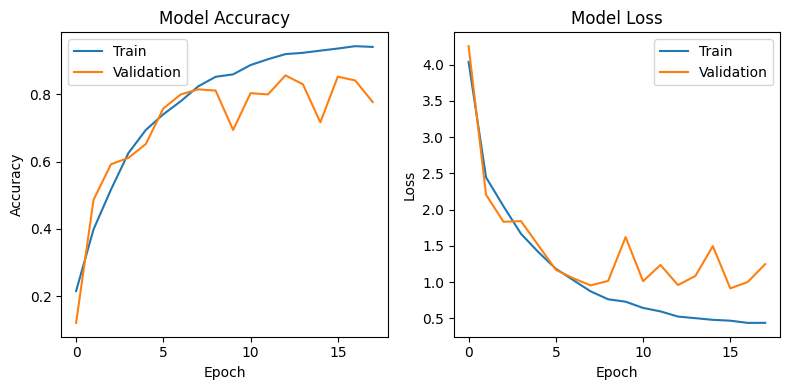

In [24]:
# Plots of the model accuracy and loss
def plot_history(history):
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

plot_history(history)

Both training and validation tend to decrease, but the validation set seems very reasonable at each epoch and although I've added various regularisations and augmentations (sometimes they just made it worse) the validation curve is not as stable as I would like, a good improvement was the decision to use 64 batches instead of 32 (it has reduced the noise a bit), same consideration for the loss curve.

Presumably, without the early stop, at some point there will be a stabilisation point where the oscillations tend to decrease.

In [25]:
#Evalutation on the test dataset
model.evaluate(test_ds)

5/5 [==============================] - 0s 21ms/step - loss: 1.0585 - sparse_categorical_accuracy: 0.8340


[1.0585216283798218, 0.8339622616767883]

I've plotted a grid of image with the true label vs the predicted one, take from one batch. As you can see most of them are well classified.



1/1 [==============================] - 0s 21ms/step


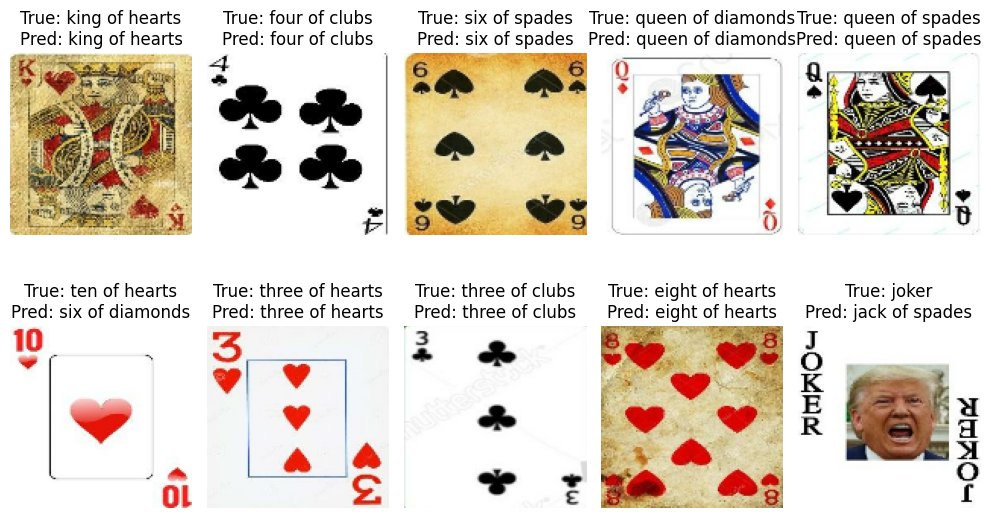

In [28]:
# Take 5 images and labels from the test set
for images, labels in test_ds.take(1):
    random_indices = np.random.choice(64, size=10, replace=False)
    test_images = images.numpy()[random_indices]
    test_labels = labels.numpy()[random_indices]


# Predict the labels of the chosen images
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

plt.figure(figsize=(10, 6))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    true_label = class_names[test_labels[i]]
    predicted_label = class_names[predicted_labels[i]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()

What I noticed about the predictions is that even if it is wrong about the number it is rare that it is also wrong about the suit(type).

### Exercise 2 (6 points): Adding modularity to the network

The purpose of this second exercise is to implement a "modular" network, in the sense we discussed in class. In particular, two variants are allowed for this exercise (<ins>only one variant should be implemented</ins>):

1.   **Variant 2a, Early-exits**: Modify the model in Exercise 1 by adding 2 or more early exits and train it.
2.   **Variant 2b, Mixture-of-experts**: Modify the model in Exercise 1 by replacing at least one layer of the model with a MoE layer.

🟩 You are free to design the model as much as you want: you can follow the slides directly (e.g., summing the losses of all early exits during training), or you can follow some of the bibliographic references in the slides, or even any other paper you find online (e.g., the MoE model may route single tokens, entire images, with different routing mechanisms, etc.).

🟥 **Please don't:**

1. Copy-paste from the web (immediate zero mark).

✍ **DESCRIPTION OF THE CODE**

*Provide a complete description of the model (what you implemented, bibliographic references, how you are training it, notable implementation issues, etc.).*

**TODO**: add a complete description here (2-3 paragraphs).

In [ ]:
# TODO: add all code here, using as many cells as you need. Train the new model.

For this exercise I decided to follow variant 2a (Early-exits) and used as a reference point the slides.

The idea of early exits is that the NN is made up of series of blocks/layers and maybe the information to understand how to classify an image is already present in the 50% of our model, of course doing the entire network may offer a better prediction but also involves more computational resources and cost.

<br>

Furthermore, this model has also a different behavior in training time and inference time, because the traing is done considering each exit but during the inference you take a decision on when to stop. In my case, I decied to use the threshold exit: gived a confindece associated to an early exit *e*, I decided to stop when $P_{e}$ > $γ$.

<br>

To reproduce the above on a practical level, I created a new template for my model that is the same as the previous one but after each conv_block I added an early exist and where each early exist consist of a classifier that has the same structure of the classification part of the original model.

<br>


For the training and inference I used the "call" method,that takes as argument:

1) "inputs" (the input data);

2) "training" (a boolean flag indicating whether the model is running in training mode);

The method iterates through the convolutional blocks of the model and performs an early exit. If the model is running in inference mode, the method checks whether the output exceeds the specified confidence threshold. If it does, the output is returned as the final output of the model, otherwise it continues to the last classifier.




In [19]:
def add_block_model(input_shape, kernel_size, n_conv_layers=1, n_filters=32, use_max_pooling = True):
    # Function that replicates the convolutional block done before
    # but the result is a Keras model in order to connect the different block in the training steps
    input = tf.keras.layers.Input(shape=input_shape)

    x = input
    for i in range(n_conv_layers):
        x = layers.Conv2D(n_filters, kernel_size, padding="SAME", kernel_regularizer=regularizers.L2(0.001))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    output = tf.keras.layers.MaxPool2D()(x)

    if use_max_pooling:
      x = layers.MaxPooling2D((2,2))(x)

    # return the inputs and outputs through tf.keras.model
    return tf.keras.Model(inputs = [input], outputs = [output])

Note that in this model I've defined an exit classifier for each block, since the exit classifier is equal to the original final classifier, the last block will be the final exit of my model, so in this implementation there are 3 exit layers.

In [29]:
# TODO: add all code here, using as many cells as you need. Train the new model.
class EarlyExit(tf.keras.Model):
    def __init__(self, exit_threshold, num_classes=53):
        super(EarlyExit, self).__init__()
        '''
          Define the components of the model
        '''

        self.exit_threshold = exit_threshold # 0.6 I picked a random value

        # It calls the function defined above
        self.conv_blocks = [
                add_block_model((120,120,3), kernel_size = 7, n_conv_layers=1, n_filters=32),
                add_block_model((60, 60, 32),  kernel_size = 5, n_conv_layers=1, n_filters=64),
                add_block_model((30, 30, 64),  kernel_size = 5, n_conv_layers=1, n_filters=128),
                add_block_model((15, 15, 128), kernel_size = 3, n_conv_layers=1, n_filters=256),
              ]

        # I defined an exit_classifier to user after each conv_block
        self.exit_classifiers = [
            tf.keras.Sequential(
                [
                    layers.Flatten(),
                    layers.Dropout(0.30),
                    tf.keras.layers.Dense(num_classes, activation="softmax"),
                ]
            )
            for _ in range(len(self.conv_blocks))
        ]

    def call(self, inputs, training=False):
        '''
          After each conv_block calculate the exit_classifier and save it
          If we are in the inference step check also if the predictions are higher of a certain threshold
        '''

        outputs = []  # save all the ouputs
        x = inputs

        for conv, exit_e in zip(self.conv_blocks, self.exit_classifiers):
            x = conv(x) # pass all the values to the add_block
            output = exit_e(x)
            outputs.append(output)  # append the current exit prediction

            # If we are in the case where the prediction is higher then the fixed threshold
            # we return the values of the last exit_classifiers computed.
            if training == False:
                if tf.reduce_any(tf.math.reduce_max(output, axis=1) > self.exit_threshold):
                    return output

        return outputs # They will be part of the loss calculation beforehand

In [42]:
loss_metric =  metrics.Mean() # Define the mean value of the loss to apply at the end

# Define a metric for each exit
num_exits = 4

# We use for updating the information about the accuracy over the batch
exits_accuracies = [ metrics.SparseCategoricalAccuracy() for _ in range(num_exits)]

# Lists in which to save the partial accuracies for Early Exit
exits_accs_list = [[] for _ in range(num_exits)]

# The list that takes into account the sum of the losses over the epochs
losses_list = []

In [43]:
# Define optimizer, number of epochs and cross entropy loss
optimizer = tf.keras.optimizers.Adam()
loss_exits = losses.SparseCategoricalCrossentropy()
epochs = 40

In [44]:
# Define the loss function as the sum of the partial ones
def joint_loss(y_true, y_pred):
    final_loss = 0

    # Loop through all the early predictions
    for pred in y_pred[:-1]:
        loss_exit = loss_exits(y_true, pred)
        final_loss = final_loss +  loss_exit

    # Loss for the final classifier
    loss_model = loss_exits(y_true, y_pred[-1])
    final_loss = final_loss + loss_model

    return final_loss

In [45]:
exit_model = EarlyExit(exit_threshold = 0.5)

In [46]:
# I reproduced a train loop similar to the one made in the lab session

# Start training
start = time.time()

# Run over each epoch
for epoch in tqdm(range(epochs)):

    print("\n Epoch %d" % (epoch))

    # Batch
    for _, (inputs, targets) in enumerate(train_ds):

        with tf.GradientTape() as tape:
          # Prediction
          outputs = exit_model(inputs, training = True)
          # Loss Function
          loss = joint_loss(targets, outputs)

        # Gradients
        grads = tape.gradient(loss, exit_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, exit_model.trainable_weights))

        # Cross Entropy Loss
        final_loss = loss_metric(loss)

        # Accuracy
        for i, acc in enumerate(exits_accuracies):
          acc.update_state(targets, outputs[i])


    # Print Loss value and update the list
    print("\nLoss:" , float(loss_metric.result()))
    losses_list.append(loss_metric.result())

    # Print the accuracies
    for i, acc in enumerate(exits_accuracies):
      if i < len(exits_accuracies) - 1:
        print("Early Exit " + str(i) + ": accuracy over epoch: %.4f" % (float(acc .result()),))
      else:
        print("Final accuracy: accuracy over epoch: %.4f" % (float(acc .result()),))

    # Store the accuracies
    for acc, acc_list in zip(exits_accuracies, exits_accs_list):
        acc_list.append(acc.result())

  0%|          | 0/40 [00:00<?, ?it/s]


 Epoch 0


  2%|▎         | 1/40 [00:22<14:27, 22.24s/it]


Loss: 55.33750534057617
Early Exit 0: accuracy over epoch: 0.1664
Early Exit 1: accuracy over epoch: 0.1767
Early Exit 2: accuracy over epoch: 0.1679
Final accuracy: accuracy over epoch: 0.1709

 Epoch 1


  5%|▌         | 2/40 [00:39<12:20, 19.50s/it]


Loss: 38.79473876953125
Early Exit 0: accuracy over epoch: 0.2474
Early Exit 1: accuracy over epoch: 0.2521
Early Exit 2: accuracy over epoch: 0.2467
Final accuracy: accuracy over epoch: 0.2629

 Epoch 2


  8%|▊         | 3/40 [01:01<12:38, 20.50s/it]


Loss: 30.84629249572754
Early Exit 0: accuracy over epoch: 0.3014
Early Exit 1: accuracy over epoch: 0.3132
Early Exit 2: accuracy over epoch: 0.3087
Final accuracy: accuracy over epoch: 0.3312

 Epoch 3


 10%|█         | 4/40 [01:19<11:43, 19.55s/it]


Loss: 25.924314498901367
Early Exit 0: accuracy over epoch: 0.3429
Early Exit 1: accuracy over epoch: 0.3649
Early Exit 2: accuracy over epoch: 0.3643
Final accuracy: accuracy over epoch: 0.3916

 Epoch 4


 12%|█▎        | 5/40 [01:38<11:16, 19.34s/it]


Loss: 22.384281158447266
Early Exit 0: accuracy over epoch: 0.3820
Early Exit 1: accuracy over epoch: 0.4118
Early Exit 2: accuracy over epoch: 0.4154
Final accuracy: accuracy over epoch: 0.4433

 Epoch 5


 15%|█▌        | 6/40 [01:56<10:41, 18.88s/it]


Loss: 19.725387573242188
Early Exit 0: accuracy over epoch: 0.4162
Early Exit 1: accuracy over epoch: 0.4537
Early Exit 2: accuracy over epoch: 0.4603
Final accuracy: accuracy over epoch: 0.4864

 Epoch 6


 18%|█▊        | 7/40 [02:15<10:22, 18.87s/it]


Loss: 17.63840675354004
Early Exit 0: accuracy over epoch: 0.4472
Early Exit 1: accuracy over epoch: 0.4924
Early Exit 2: accuracy over epoch: 0.4993
Final accuracy: accuracy over epoch: 0.5258

 Epoch 7


 20%|██        | 8/40 [02:34<10:02, 18.83s/it]


Loss: 15.954440116882324
Early Exit 0: accuracy over epoch: 0.4765
Early Exit 1: accuracy over epoch: 0.5248
Early Exit 2: accuracy over epoch: 0.5334
Final accuracy: accuracy over epoch: 0.5590

 Epoch 8


 22%|██▎       | 9/40 [02:53<09:44, 18.86s/it]


Loss: 14.559205055236816
Early Exit 0: accuracy over epoch: 0.5041
Early Exit 1: accuracy over epoch: 0.5552
Early Exit 2: accuracy over epoch: 0.5638
Final accuracy: accuracy over epoch: 0.5891

 Epoch 9


 25%|██▌       | 10/40 [03:10<09:14, 18.49s/it]


Loss: 13.372706413269043
Early Exit 0: accuracy over epoch: 0.5297
Early Exit 1: accuracy over epoch: 0.5829
Early Exit 2: accuracy over epoch: 0.5923
Final accuracy: accuracy over epoch: 0.6158

 Epoch 10


 28%|██▊       | 11/40 [03:29<08:58, 18.56s/it]


Loss: 12.375509262084961
Early Exit 0: accuracy over epoch: 0.5522
Early Exit 1: accuracy over epoch: 0.6074
Early Exit 2: accuracy over epoch: 0.6174
Final accuracy: accuracy over epoch: 0.6400

 Epoch 11


 30%|███       | 12/40 [03:47<08:33, 18.33s/it]


Loss: 11.513026237487793
Early Exit 0: accuracy over epoch: 0.5733
Early Exit 1: accuracy over epoch: 0.6295
Early Exit 2: accuracy over epoch: 0.6406
Final accuracy: accuracy over epoch: 0.6615

 Epoch 12


 32%|███▎      | 13/40 [04:06<08:20, 18.52s/it]


Loss: 10.766417503356934
Early Exit 0: accuracy over epoch: 0.5919
Early Exit 1: accuracy over epoch: 0.6495
Early Exit 2: accuracy over epoch: 0.6616
Final accuracy: accuracy over epoch: 0.6813

 Epoch 13


 35%|███▌      | 14/40 [04:24<07:56, 18.31s/it]


Loss: 10.118237495422363
Early Exit 0: accuracy over epoch: 0.6083
Early Exit 1: accuracy over epoch: 0.6669
Early Exit 2: accuracy over epoch: 0.6795
Final accuracy: accuracy over epoch: 0.6985

 Epoch 14


 38%|███▊      | 15/40 [04:42<07:41, 18.45s/it]


Loss: 9.536194801330566
Early Exit 0: accuracy over epoch: 0.6238
Early Exit 1: accuracy over epoch: 0.6838
Early Exit 2: accuracy over epoch: 0.6965
Final accuracy: accuracy over epoch: 0.7145

 Epoch 15


 40%|████      | 16/40 [05:00<07:18, 18.29s/it]


Loss: 9.021389961242676
Early Exit 0: accuracy over epoch: 0.6380
Early Exit 1: accuracy over epoch: 0.6989
Early Exit 2: accuracy over epoch: 0.7118
Final accuracy: accuracy over epoch: 0.7289

 Epoch 16


 42%|████▎     | 17/40 [05:19<07:06, 18.52s/it]


Loss: 8.563040733337402
Early Exit 0: accuracy over epoch: 0.6515
Early Exit 1: accuracy over epoch: 0.7122
Early Exit 2: accuracy over epoch: 0.7253
Final accuracy: accuracy over epoch: 0.7418

 Epoch 17


 45%|████▌     | 18/40 [05:40<07:00, 19.12s/it]


Loss: 8.152837753295898
Early Exit 0: accuracy over epoch: 0.6640
Early Exit 1: accuracy over epoch: 0.7239
Early Exit 2: accuracy over epoch: 0.7376
Final accuracy: accuracy over epoch: 0.7532

 Epoch 18


 48%|████▊     | 19/40 [05:59<06:41, 19.11s/it]


Loss: 7.773644924163818
Early Exit 0: accuracy over epoch: 0.6754
Early Exit 1: accuracy over epoch: 0.7355
Early Exit 2: accuracy over epoch: 0.7493
Final accuracy: accuracy over epoch: 0.7641

 Epoch 19


 50%|█████     | 20/40 [06:17<06:15, 18.76s/it]


Loss: 7.434980392456055
Early Exit 0: accuracy over epoch: 0.6858
Early Exit 1: accuracy over epoch: 0.7459
Early Exit 2: accuracy over epoch: 0.7593
Final accuracy: accuracy over epoch: 0.7742

 Epoch 20


 52%|█████▎    | 21/40 [06:37<06:03, 19.13s/it]


Loss: 7.120015621185303
Early Exit 0: accuracy over epoch: 0.6959
Early Exit 1: accuracy over epoch: 0.7559
Early Exit 2: accuracy over epoch: 0.7691
Final accuracy: accuracy over epoch: 0.7834

 Epoch 21


 55%|█████▌    | 22/40 [06:55<05:37, 18.77s/it]


Loss: 6.832183837890625
Early Exit 0: accuracy over epoch: 0.7054
Early Exit 1: accuracy over epoch: 0.7650
Early Exit 2: accuracy over epoch: 0.7779
Final accuracy: accuracy over epoch: 0.7919

 Epoch 22


 57%|█████▊    | 23/40 [07:14<05:19, 18.77s/it]


Loss: 6.57097053527832
Early Exit 0: accuracy over epoch: 0.7135
Early Exit 1: accuracy over epoch: 0.7732
Early Exit 2: accuracy over epoch: 0.7861
Final accuracy: accuracy over epoch: 0.7996

 Epoch 23


 60%|██████    | 24/40 [07:31<04:55, 18.48s/it]


Loss: 6.327840328216553
Early Exit 0: accuracy over epoch: 0.7215
Early Exit 1: accuracy over epoch: 0.7809
Early Exit 2: accuracy over epoch: 0.7938
Final accuracy: accuracy over epoch: 0.8068

 Epoch 24


 62%|██████▎   | 25/40 [08:12<06:18, 25.23s/it]


Loss: 6.109347820281982
Early Exit 0: accuracy over epoch: 0.7285
Early Exit 1: accuracy over epoch: 0.7875
Early Exit 2: accuracy over epoch: 0.8007
Final accuracy: accuracy over epoch: 0.8130

 Epoch 25


 65%|██████▌   | 26/40 [08:31<05:24, 23.15s/it]


Loss: 5.9030561447143555
Early Exit 0: accuracy over epoch: 0.7352
Early Exit 1: accuracy over epoch: 0.7942
Early Exit 2: accuracy over epoch: 0.8072
Final accuracy: accuracy over epoch: 0.8192

 Epoch 26


 68%|██████▊   | 27/40 [08:50<04:48, 22.16s/it]


Loss: 5.711197376251221
Early Exit 0: accuracy over epoch: 0.7417
Early Exit 1: accuracy over epoch: 0.8004
Early Exit 2: accuracy over epoch: 0.8132
Final accuracy: accuracy over epoch: 0.8250

 Epoch 27


 70%|███████   | 28/40 [09:10<04:16, 21.37s/it]


Loss: 5.529898643493652
Early Exit 0: accuracy over epoch: 0.7480
Early Exit 1: accuracy over epoch: 0.8062
Early Exit 2: accuracy over epoch: 0.8191
Final accuracy: accuracy over epoch: 0.8304

 Epoch 28


 72%|███████▎  | 29/40 [09:29<03:47, 20.69s/it]


Loss: 5.361575603485107
Early Exit 0: accuracy over epoch: 0.7541
Early Exit 1: accuracy over epoch: 0.8114
Early Exit 2: accuracy over epoch: 0.8244
Final accuracy: accuracy over epoch: 0.8355

 Epoch 29


 75%|███████▌  | 30/40 [09:47<03:18, 19.84s/it]


Loss: 5.204190731048584
Early Exit 0: accuracy over epoch: 0.7595
Early Exit 1: accuracy over epoch: 0.8166
Early Exit 2: accuracy over epoch: 0.8294
Final accuracy: accuracy over epoch: 0.8402

 Epoch 30


 78%|███████▊  | 31/40 [10:06<02:56, 19.57s/it]


Loss: 5.054285526275635
Early Exit 0: accuracy over epoch: 0.7650
Early Exit 1: accuracy over epoch: 0.8217
Early Exit 2: accuracy over epoch: 0.8341
Final accuracy: accuracy over epoch: 0.8447

 Epoch 31


 80%|████████  | 32/40 [10:24<02:32, 19.12s/it]


Loss: 4.914825916290283
Early Exit 0: accuracy over epoch: 0.7701
Early Exit 1: accuracy over epoch: 0.8262
Early Exit 2: accuracy over epoch: 0.8386
Final accuracy: accuracy over epoch: 0.8488

 Epoch 32


 82%|████████▎ | 33/40 [10:43<02:13, 19.01s/it]


Loss: 4.7842698097229
Early Exit 0: accuracy over epoch: 0.7747
Early Exit 1: accuracy over epoch: 0.8304
Early Exit 2: accuracy over epoch: 0.8428
Final accuracy: accuracy over epoch: 0.8528

 Epoch 33


 85%|████████▌ | 34/40 [11:02<01:53, 18.97s/it]


Loss: 4.659383773803711
Early Exit 0: accuracy over epoch: 0.7794
Early Exit 1: accuracy over epoch: 0.8344
Early Exit 2: accuracy over epoch: 0.8468
Final accuracy: accuracy over epoch: 0.8565

 Epoch 34


 88%|████████▊ | 35/40 [11:20<01:34, 18.90s/it]


Loss: 4.542459487915039
Early Exit 0: accuracy over epoch: 0.7835
Early Exit 1: accuracy over epoch: 0.8384
Early Exit 2: accuracy over epoch: 0.8505
Final accuracy: accuracy over epoch: 0.8600

 Epoch 35


 90%|█████████ | 36/40 [11:38<01:14, 18.59s/it]


Loss: 4.432860851287842
Early Exit 0: accuracy over epoch: 0.7877
Early Exit 1: accuracy over epoch: 0.8420
Early Exit 2: accuracy over epoch: 0.8539
Final accuracy: accuracy over epoch: 0.8631

 Epoch 36


 92%|█████████▎| 37/40 [11:57<00:56, 18.72s/it]


Loss: 4.326697826385498
Early Exit 0: accuracy over epoch: 0.7917
Early Exit 1: accuracy over epoch: 0.8455
Early Exit 2: accuracy over epoch: 0.8574
Final accuracy: accuracy over epoch: 0.8663

 Epoch 37


 95%|█████████▌| 38/40 [12:15<00:36, 18.47s/it]


Loss: 4.22564697265625
Early Exit 0: accuracy over epoch: 0.7956
Early Exit 1: accuracy over epoch: 0.8488
Early Exit 2: accuracy over epoch: 0.8607
Final accuracy: accuracy over epoch: 0.8693

 Epoch 38


 98%|█████████▊| 39/40 [12:34<00:18, 18.60s/it]


Loss: 4.129186630249023
Early Exit 0: accuracy over epoch: 0.7994
Early Exit 1: accuracy over epoch: 0.8520
Early Exit 2: accuracy over epoch: 0.8638
Final accuracy: accuracy over epoch: 0.8722

 Epoch 39


100%|██████████| 40/40 [12:52<00:00, 19.31s/it]


Loss: 4.038592338562012
Early Exit 0: accuracy over epoch: 0.8029
Early Exit 1: accuracy over epoch: 0.8550
Early Exit 2: accuracy over epoch: 0.8668
Final accuracy: accuracy over epoch: 0.8749


**INFERENCE STEP**

Let's see how it works during inference time

In [49]:
test_acc = metrics.SparseCategoricalAccuracy()

for step, (inputs, targets) in enumerate(test_ds.take(1)):
  for input, target in zip(inputs, targets):
    output = exit_model(inputs, training = False)
    test_acc.update_state(targets, output)

In [50]:

print("Test Accuracy: %.4f" % (float(test_acc.result()),))
test_acc.reset_states()

Test Accuracy: 0.6875


✍ **RESULTS AND EVALUATION**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly (e.g., the average accuracy of each early exit). Explain them in code or in text, equivalently.*

In [ ]:
# TODO: Add results here (anything appropriate is okay).

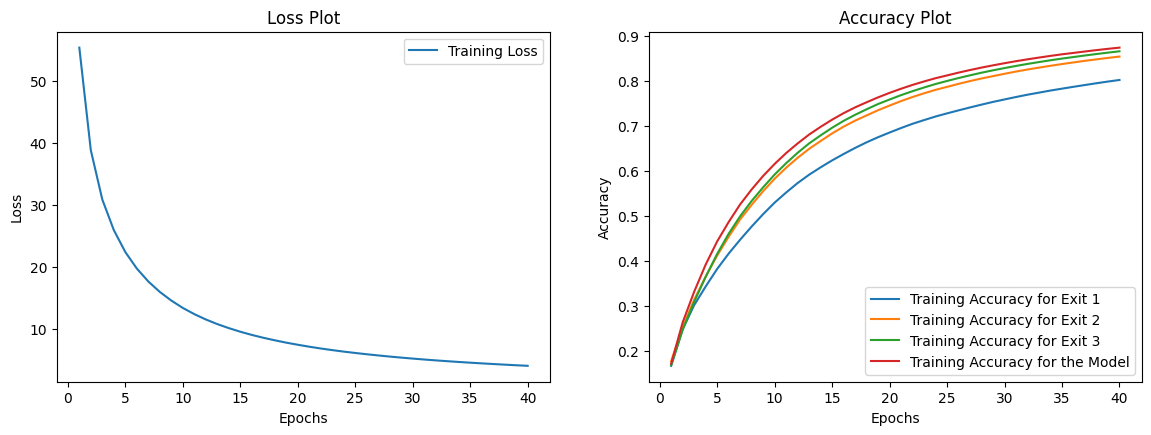

In [51]:
# Simulated for each epoch
n_epochs = np.arange(1, epochs + 1)

plt.figure(figsize = (14, 10))

# Plot Loss
plt.subplot(221)
plt.plot(n_epochs, losses_list, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()


plt.subplot(222)
# Plot Accuracy for multiple exits
for i, accs in enumerate(exits_accs_list):
    if i < 3:
      plt.plot(n_epochs, accs, label=f'Training Accuracy for Exit {i+1}')
    else:
      plt.plot(n_epochs, accs, label=f'Training Accuracy for the Model')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.show()



First of all, we can say that the model has been trained correctly, as the accuracies increase from epoch to epoch.

The first thing we can deduce from looking at the accuracy plot is that our model certainly reports an overfitting situation, as the difference in output during the inference time is quite high.

Looking at the first results it seemed that the second exit was the best choice but after a while the third exit became the dominant one.

Overall, looking at the different early_exits, it seems that despite the first early exit, there is not much difference between the other two exits. In other words, using this code, for this model doesn't change that much with respect to the full model.

### Exercise 3 (5 points): Load balancing regularization

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 4.5/6). For a mark of 4.5/6 or higher, an additional point can also be recovered during the exam.**

**To recap**: if you submitted the mid-term homework, implement only Exercises 1 and 2, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1, 2, and 3 for a total of *15 points*.

For this exercise, you are asked to implement an additional **regularization term** as follows:

1.   If you followed variant 2a, add a regularization term that will balance the number of elements exiting at each early exit (e.g., a KL divergence w.r.t. an uniform distribution).
2.   If you followed variant 2b, add a regularization term that will balance the amount of tokens (or inputs) that each expert received (e.g., a KL divergence w.r.t. to an uniform distribution).

You have freedom here to follow the ideas from the slides or other ideas you may find in the literature.


✍ **DESCRIPTION OF THE CODE**

*Provide a complete description of the regularization term you implemented.*

**TODO**: add description (1-2 paragraphs).

For this exercise I'll do the point 1 since I've done the point 2a previously and used as a reference point the slides.

Assume that choosing an exit can be accomplished by a relatively simple network. We plan to introduce an initial block at the beginning of the model, so called "Exit Selector.", The purpose of this block is to determine, a priori, which exit should be taken during the training phase.


The Exit Selector directly processes the input image to identify the appropriate exit by exploring all of them and producing a predictions. So for each input, the predictions will be a weighted average of the predictions received in the exits with the probabilities generated by the exits selection block as weights.

\begin{equation}
\widehat{y} = \sum_{e} \text{softmax}_e(c) \times \widehat{y}_e
\end{equation}

After this we take the probabilty of the vectors and impose them to be close to a prior probability (in this case uniform) by regularazing their KL divergence.

During inference, the exit will be selected by taking the argmax of the computed probability distribution.


In [78]:
import tensorflow as tf

def update_tensor(current_tensor, tensor_to_add, row_idxs):
    """
      In this functions we are going to update (replace)
      some values of the current tensor according to the row_idxs
    """

    # Check if row_ids is empty
    if tf.size(row_idxs) == 0:
        return current_tensor,


    #  Check if row_ids is only a single number or not
    if tf.rank(row_idxs) == 0:
        indices = tf.expand_dims([row_idxs], axis=0)
    else:
        indices = tf.reshape(row_idxs, [-1, 1])  # Reshaping row_ids to match the outer dimensions of new_tensor

    # function that takes an input tensor and updates it with new values at specific indices
    output_tensor = tf.tensor_scatter_nd_update(current_tensor, indices, tensor_to_add)

    return output_tensor

In [86]:
# TODO: add all code here, using as many cells as you need. Train the new model.
class Exit_balanced(tf.keras.Model):
    def __init__(self, num_classes=53):
        super(Exit_balanced, self).__init__()

        # Use the same block and function defined before
        self.conv_blocks = [
                add_block_model((120,120,3), kernel_size = 7, n_conv_layers=1, n_filters=32),
                add_block_model((60, 60, 32),  kernel_size = 5, n_conv_layers=1, n_filters=64),
                add_block_model((30, 30, 64),  kernel_size = 5, n_conv_layers=1, n_filters=128),
                add_block_model((15, 15, 128), kernel_size = 3, n_conv_layers=1, n_filters=256),
              ]

        # Define the exit selector
        self.exit_selector = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(len(self.conv_blocks), activation='softmax')
        ])

        # classifier for each conv_block
        self.exit_classifiers = [
            tf.keras.Sequential(
                [
                    layers.Flatten(),
                    layers.Dropout(0.30),
                    tf.keras.layers.Dense(num_classes, activation="softmax"),
                ]
            )
            for _ in range(len(self.conv_blocks))
        ]

    def call(self, x, training=False):
        '''
          Training part is the same as before with the only difference being the output
          which are multiplied by the probabilities generated by the exit selector block
        '''

        outputs = []  # save all the ouputs

         # Calculate the exit selector
        prob_y = self.exit_selector(x)

        if training == True:

          for conv, exit_e in zip(self.conv_blocks, self.exit_classifiers):
            x = conv(x) # pass all the values to the add_block
            output = exit_e(x)
            outputs.append(output)  # append the current exit prediction

          final_output = 0
          for i, exit in enumerate(outputs):
            final_output += exit*tf.expand_dims(prob_y[:, i], axis=1)

          return final_output, prob_y

        else:
          '''
            We start with the output_tensor that represents a sample in my batch
            When a sample takes an "early exit," I need to update that sample's corresponding row with the output
            obtained from the exit from which it came.
          '''

          # onbtain the batch size and initialize the tensor
          batch_size = tf.shape(inputs)[0]
          zero_tensor = tf.zeros((batch_size, 53), dtype=tf.float32)

          # compute the argmax
          argmax_prob = tf.argmax(prob_y, axis=1)

          early_exit_idx_map = {
              0: tf.where(argmax_prob == 0),
              1: tf.where(argmax_prob == 1),
              2: tf.where(argmax_prob == 2),
              3: tf.where(argmax_prob == 3)
          }

          idx_exit = 0

          for conv, exit_e in zip(self.conv_blocks, self.exit_classifiers):
              x = conv(x) # pass all the values to the add_block

              # Select those values that exit at the exit-idx_exit
              x_selected_exit_e = tf.boolean_mask(x,tf.equal(argmax_prob, idx_exit))

              # For that elements apply the classifier
              output_exit = exit_e(x_selected_exit_e)

              # Update the output tensor with the values obteined before
              if idx_exit == 0:
                output_tensor= update_tensor(zero_tensor, output_exit, early_exit_idx_map[idx_exit])
              else:
                output_tensor= update_tensor(output_tensor, output_exit, early_exit_idx_map[idx_exit])

              idx_exit +=1

          # Calculate distr_exits from early_exit_idx_map
          distr_exits = [1 if isinstance(val, int) else len(val) for val in early_exit_idx_map.values()]

          return output_tensor, distr_exits

In [87]:
# let's initialize the optimization, model and the loss
model_balanced = Exit_balanced()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) #I've changed the learning rate because before It used to swing too much
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
loss_exit_2 = losses.SparseCategoricalCrossentropy()

In [88]:
# define the ouputs for the training time
total_loss_list = [] #list that take into account all the losses over epochs
accuracy_epochs = []

# vector for the probabilities
mean_prob_train = [[] for _ in range(4)]

epochs = 40

In [89]:
loss_metric =  metrics.Mean() # Define the loss to apply at the end

In [90]:
start_time = time.time()
for epoch in tqdm(range(epochs)):

    print("\n Epoch %d" % (epoch))

    # lists for intermediate results
    mean_distr_probs_over_epoch = []

    # Batch
    for  x_train, y_train in train_ds:

        with tf.GradientTape() as tape:
            # Prediction
            predictions, probs = model_balanced(x_train, training=True)

            # Loss Function for the exits
            #loss_ = losses.SparseCategoricalCrossentropy()
            loss_preds = tf.math.reduce_sum(loss_exit_2 (y_train, predictions))
            mean_distr = tf.reduce_mean(probs, axis=0)

            # Loss_distr is a measure of the divergence of the mean distribution of predicted
            loss_distr = tf.math.reduce_sum(tf.keras.losses.KLDivergence()(tf.constant([0.2]*4), mean_distr))

            # Total loss
            total_loss = loss_preds + loss_distr

            # append the intermediate results
            mean_distr_probs_over_epoch.append(mean_distr.numpy())

        # Gradients
        grads = tape.gradient(total_loss, model_balanced.trainable_weights)
        optimizer.apply_gradients(zip(grads, model_balanced.trainable_weights))

        # Compute the mean of the total loss
        final_loss = loss_metric(total_loss)

        # Accuracy
        train_accuracy.update_state(y_train, predictions)


    print("\nTotal Loss: %.4f" %  (float(loss_metric.result())))
    print("Accuracy: %.4f " % (train_accuracy.result().numpy()))

    # mean load of each exit
    mean_probs = tf.reduce_mean(mean_distr_probs_over_epoch, axis=0)

    for i in range(4):
      mean_prob_train[i].append(mean_probs[i])

    print("Probability for each exit :  Exit_1: %.4f - Exit_2 : %.4f  - Exit_3 : %.4f - final_exit : %.4f" % (mean_probs[0] ,mean_probs[1] , mean_probs[2], mean_probs[3]))

    # update the total loss, partial loss and accuracy
    total_loss_list.append(loss_metric.result())
    accuracy_epochs.append(train_accuracy.result().numpy())

    train_accuracy.reset_states() #when you move on to the next epoch

  0%|          | 0/40 [00:00<?, ?it/s]


 Epoch 0


  2%|▎         | 1/40 [00:23<15:28, 23.82s/it]


Total Loss: 3.3748
Accuracy: 0.1788 
Probability for each exit :  Exit_1: 0.1480 - Exit_2 : 0.2102  - Exit_3 : 0.2638 - final_exit : 0.3781

 Epoch 1


  5%|▌         | 2/40 [00:43<13:32, 21.38s/it]


Total Loss: 2.8975
Accuracy: 0.2991 
Probability for each exit :  Exit_1: 0.1418 - Exit_2 : 0.2019  - Exit_3 : 0.2859 - final_exit : 0.3703

 Epoch 2


  8%|▊         | 3/40 [01:02<12:26, 20.18s/it]


Total Loss: 2.6594
Accuracy: 0.3477 
Probability for each exit :  Exit_1: 0.1375 - Exit_2 : 0.1968  - Exit_3 : 0.2982 - final_exit : 0.3674

 Epoch 3


 10%|█         | 4/40 [01:21<11:59, 19.99s/it]


Total Loss: 2.5023
Accuracy: 0.3741 
Probability for each exit :  Exit_1: 0.1323 - Exit_2 : 0.1914  - Exit_3 : 0.3047 - final_exit : 0.3716

 Epoch 4


 12%|█▎        | 5/40 [01:40<11:25, 19.58s/it]


Total Loss: 2.3624
Accuracy: 0.4233 
Probability for each exit :  Exit_1: 0.1359 - Exit_2 : 0.1922  - Exit_3 : 0.3011 - final_exit : 0.3709

 Epoch 5


 15%|█▌        | 6/40 [02:00<11:07, 19.63s/it]


Total Loss: 2.2478
Accuracy: 0.4547 
Probability for each exit :  Exit_1: 0.1358 - Exit_2 : 0.1925  - Exit_3 : 0.3006 - final_exit : 0.3711

 Epoch 6


 18%|█▊        | 7/40 [02:19<10:36, 19.28s/it]


Total Loss: 2.1473
Accuracy: 0.4894 
Probability for each exit :  Exit_1: 0.1356 - Exit_2 : 0.1950  - Exit_3 : 0.2969 - final_exit : 0.3725

 Epoch 7


 20%|██        | 8/40 [02:38<10:20, 19.39s/it]


Total Loss: 2.0602
Accuracy: 0.5052 
Probability for each exit :  Exit_1: 0.1323 - Exit_2 : 0.1964  - Exit_3 : 0.2952 - final_exit : 0.3761

 Epoch 8


 22%|██▎       | 9/40 [02:57<09:53, 19.16s/it]


Total Loss: 1.9803
Accuracy: 0.5462 
Probability for each exit :  Exit_1: 0.1316 - Exit_2 : 0.1914  - Exit_3 : 0.2940 - final_exit : 0.3830

 Epoch 9


 25%|██▌       | 10/40 [03:17<09:39, 19.32s/it]


Total Loss: 1.9098
Accuracy: 0.5483 
Probability for each exit :  Exit_1: 0.1337 - Exit_2 : 0.1921  - Exit_3 : 0.2964 - final_exit : 0.3778

 Epoch 10


 28%|██▊       | 11/40 [03:37<09:30, 19.69s/it]


Total Loss: 1.8445
Accuracy: 0.5984 
Probability for each exit :  Exit_1: 0.1304 - Exit_2 : 0.1946  - Exit_3 : 0.2909 - final_exit : 0.3841

 Epoch 11


 30%|███       | 12/40 [03:56<09:02, 19.39s/it]


Total Loss: 1.7886
Accuracy: 0.6058 
Probability for each exit :  Exit_1: 0.1295 - Exit_2 : 0.1881  - Exit_3 : 0.2977 - final_exit : 0.3847

 Epoch 12


 32%|███▎      | 13/40 [04:16<08:48, 19.56s/it]


Total Loss: 1.7348
Accuracy: 0.6233 
Probability for each exit :  Exit_1: 0.1323 - Exit_2 : 0.1899  - Exit_3 : 0.2880 - final_exit : 0.3899

 Epoch 13


 35%|███▌      | 14/40 [04:35<08:25, 19.43s/it]


Total Loss: 1.6840
Accuracy: 0.6449 
Probability for each exit :  Exit_1: 0.1297 - Exit_2 : 0.1898  - Exit_3 : 0.2896 - final_exit : 0.3909

 Epoch 14


 38%|███▊      | 15/40 [04:55<08:09, 19.56s/it]


Total Loss: 1.6381
Accuracy: 0.6607 
Probability for each exit :  Exit_1: 0.1305 - Exit_2 : 0.1898  - Exit_3 : 0.2864 - final_exit : 0.3933

 Epoch 15


 40%|████      | 16/40 [05:14<07:44, 19.34s/it]


Total Loss: 1.5953
Accuracy: 0.6743 
Probability for each exit :  Exit_1: 0.1277 - Exit_2 : 0.1895  - Exit_3 : 0.2874 - final_exit : 0.3954

 Epoch 16


 42%|████▎     | 17/40 [05:33<07:25, 19.39s/it]


Total Loss: 1.5544
Accuracy: 0.6941 
Probability for each exit :  Exit_1: 0.1272 - Exit_2 : 0.1920  - Exit_3 : 0.2831 - final_exit : 0.3977

 Epoch 17


 45%|████▌     | 18/40 [05:53<07:10, 19.58s/it]


Total Loss: 1.5163
Accuracy: 0.7011 
Probability for each exit :  Exit_1: 0.1285 - Exit_2 : 0.1898  - Exit_3 : 0.2830 - final_exit : 0.3988

 Epoch 18


 48%|████▊     | 19/40 [06:13<06:52, 19.62s/it]


Total Loss: 1.4813
Accuracy: 0.7133 
Probability for each exit :  Exit_1: 0.1290 - Exit_2 : 0.1904  - Exit_3 : 0.2812 - final_exit : 0.3994

 Epoch 19


 50%|█████     | 20/40 [06:33<06:33, 19.65s/it]


Total Loss: 1.4481
Accuracy: 0.7223 
Probability for each exit :  Exit_1: 0.1290 - Exit_2 : 0.1873  - Exit_3 : 0.2795 - final_exit : 0.4041

 Epoch 20


 52%|█████▎    | 21/40 [06:51<06:08, 19.40s/it]


Total Loss: 1.4172
Accuracy: 0.7377 
Probability for each exit :  Exit_1: 0.1289 - Exit_2 : 0.1867  - Exit_3 : 0.2805 - final_exit : 0.4039

 Epoch 21


 55%|█████▌    | 22/40 [07:11<05:51, 19.55s/it]


Total Loss: 1.3881
Accuracy: 0.7467 
Probability for each exit :  Exit_1: 0.1288 - Exit_2 : 0.1879  - Exit_3 : 0.2807 - final_exit : 0.4026

 Epoch 22


 57%|█████▊    | 23/40 [07:30<05:30, 19.43s/it]


Total Loss: 1.3608
Accuracy: 0.7539 
Probability for each exit :  Exit_1: 0.1275 - Exit_2 : 0.1887  - Exit_3 : 0.2777 - final_exit : 0.4061

 Epoch 23


 60%|██████    | 24/40 [07:50<05:10, 19.41s/it]


Total Loss: 1.3354
Accuracy: 0.7567 
Probability for each exit :  Exit_1: 0.1276 - Exit_2 : 0.1874  - Exit_3 : 0.2763 - final_exit : 0.4087

 Epoch 24


 62%|██████▎   | 25/40 [08:09<04:52, 19.48s/it]


Total Loss: 1.3114
Accuracy: 0.7636 
Probability for each exit :  Exit_1: 0.1281 - Exit_2 : 0.1815  - Exit_3 : 0.2809 - final_exit : 0.4095

 Epoch 25


 65%|██████▌   | 26/40 [08:28<04:28, 19.20s/it]


Total Loss: 1.2886
Accuracy: 0.7643 
Probability for each exit :  Exit_1: 0.1264 - Exit_2 : 0.1826  - Exit_3 : 0.2800 - final_exit : 0.4110

 Epoch 26


 68%|██████▊   | 27/40 [08:48<04:12, 19.40s/it]


Total Loss: 1.2666
Accuracy: 0.7827 
Probability for each exit :  Exit_1: 0.1273 - Exit_2 : 0.1826  - Exit_3 : 0.2730 - final_exit : 0.4171

 Epoch 27


 70%|███████   | 28/40 [09:07<03:50, 19.21s/it]


Total Loss: 1.2451
Accuracy: 0.7968 
Probability for each exit :  Exit_1: 0.1264 - Exit_2 : 0.1820  - Exit_3 : 0.2722 - final_exit : 0.4193

 Epoch 28


 72%|███████▎  | 29/40 [09:26<03:32, 19.30s/it]


Total Loss: 1.2252
Accuracy: 0.7981 
Probability for each exit :  Exit_1: 0.1260 - Exit_2 : 0.1817  - Exit_3 : 0.2734 - final_exit : 0.4189

 Epoch 29


 75%|███████▌  | 30/40 [09:47<03:16, 19.67s/it]


Total Loss: 1.2067
Accuracy: 0.7908 
Probability for each exit :  Exit_1: 0.1254 - Exit_2 : 0.1793  - Exit_3 : 0.2746 - final_exit : 0.4207

 Epoch 30


 78%|███████▊  | 31/40 [10:05<02:54, 19.40s/it]


Total Loss: 1.1879
Accuracy: 0.8217 
Probability for each exit :  Exit_1: 0.1250 - Exit_2 : 0.1796  - Exit_3 : 0.2734 - final_exit : 0.4220

 Epoch 31


 80%|████████  | 32/40 [10:25<02:36, 19.53s/it]


Total Loss: 1.1704
Accuracy: 0.8107 
Probability for each exit :  Exit_1: 0.1251 - Exit_2 : 0.1789  - Exit_3 : 0.2730 - final_exit : 0.4230

 Epoch 32


 82%|████████▎ | 33/40 [10:44<02:15, 19.30s/it]


Total Loss: 1.1535
Accuracy: 0.8161 
Probability for each exit :  Exit_1: 0.1251 - Exit_2 : 0.1747  - Exit_3 : 0.2725 - final_exit : 0.4277

 Epoch 33


 85%|████████▌ | 34/40 [11:04<01:56, 19.38s/it]


Total Loss: 1.1378
Accuracy: 0.8177 
Probability for each exit :  Exit_1: 0.1251 - Exit_2 : 0.1771  - Exit_3 : 0.2743 - final_exit : 0.4234

 Epoch 34


 88%|████████▊ | 35/40 [11:22<01:35, 19.12s/it]


Total Loss: 1.1217
Accuracy: 0.8364 
Probability for each exit :  Exit_1: 0.1245 - Exit_2 : 0.1752  - Exit_3 : 0.2714 - final_exit : 0.4290

 Epoch 35


 90%|█████████ | 36/40 [11:42<01:17, 19.40s/it]


Total Loss: 1.1067
Accuracy: 0.8343 
Probability for each exit :  Exit_1: 0.1249 - Exit_2 : 0.1735  - Exit_3 : 0.2725 - final_exit : 0.4291

 Epoch 36


 92%|█████████▎| 37/40 [12:03<00:59, 19.81s/it]


Total Loss: 1.0922
Accuracy: 0.8299 
Probability for each exit :  Exit_1: 0.1238 - Exit_2 : 0.1769  - Exit_3 : 0.2763 - final_exit : 0.4231

 Epoch 37


 95%|█████████▌| 38/40 [12:21<00:38, 19.42s/it]


Total Loss: 1.0786
Accuracy: 0.8270 
Probability for each exit :  Exit_1: 0.1243 - Exit_2 : 0.1688  - Exit_3 : 0.2777 - final_exit : 0.4292

 Epoch 38


 98%|█████████▊| 39/40 [12:41<00:19, 19.48s/it]


Total Loss: 1.0649
Accuracy: 0.8421 
Probability for each exit :  Exit_1: 0.1244 - Exit_2 : 0.1736  - Exit_3 : 0.2762 - final_exit : 0.4257

 Epoch 39


100%|██████████| 40/40 [13:00<00:00, 19.51s/it]


Total Loss: 1.0517
Accuracy: 0.8448 
Probability for each exit :  Exit_1: 0.1238 - Exit_2 : 0.1739  - Exit_3 : 0.2753 - final_exit : 0.4271


INFERENCE STEP

In [95]:
test_acc = metrics.SparseCategoricalAccuracy()

for step, (inputs, targets) in enumerate(test_ds.take(1)):
  for input, target in zip(inputs, targets):
    output = model_balanced(inputs, training = False)
    test_acc.update_state(targets, output[0])

In [96]:
print(test_acc.result())

tf.Tensor(0.59375, shape=(), dtype=float32)


✍ **RESULTS AND EVALUATION**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly (e.g., the load for each expert when training). Explain them in code or in text, equivalently.*

In [90]:
# TODO: Add results here (anything appropriate is okay).

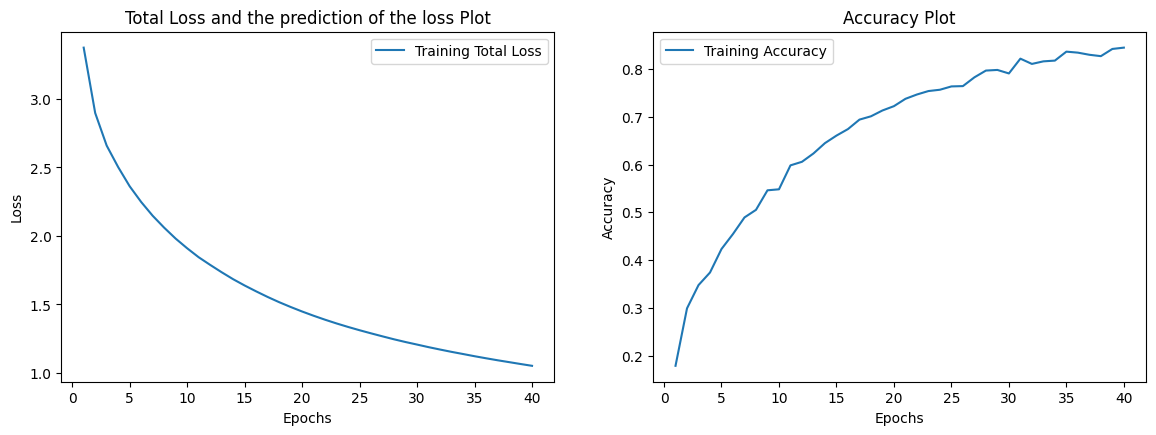

In [93]:
# Simulated for each epoch
n_epochs = np.arange(1, epochs + 1)

plt.figure(figsize = (14, 10))

# Plot Loss
plt.subplot(221)
plt.plot(n_epochs, total_loss_list, label='Training Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Total Loss and the prediction of the loss Plot')
plt.legend()


plt.subplot(222)
# Plot Accuracy for multiple exits
plt.plot(n_epochs, accuracy_epochs, label=f'Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

As we can see the modal is trained correctly looking at the loss and accuracy curve, a little detail that one can se is in this case acccuracy plot respect to the plot of the previuous example there is a little bit of noise due to the fact the of the constrait of the exit. With regard to the distribution of probabilities, we can observe them better in the following graph.

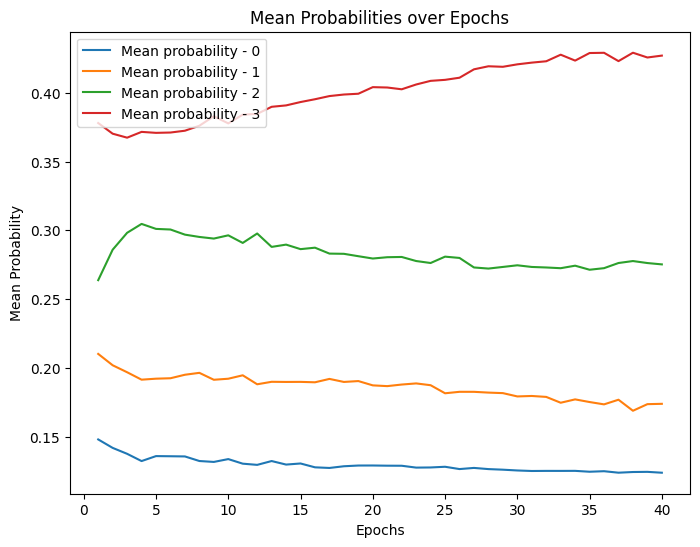

In [94]:
n_epochs = np.arange(1, epochs + 1)

plt.figure(figsize = (8, 6))

for i , mean_prob in enumerate(mean_prob_train):
  plt.plot(n_epochs, mean_prob, label=f'Mean probability - {i}')

plt.title('Mean Probabilities over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Probability')
plt.legend()

plt.show()

What we can see as it was aspected the two first exit doesn't give us a good result so they work better in few case, addiotionali looks like the second is going to converge with the first. On the other hand, it seems that the second has a good change to be chose by the exit selector prevalence maybe if with a much higher number of epochs it will be closer to the second exit or not.

Unfortunately I cannot increase the number of epochs that much due to the colab limitation, to see if they get a stabilization point.

The last thing to say about this result and the previous one (exercise 2) is that it looks like the last layer is not so useful, or rather for this dataset,in some cases a model with 3 convolutional blocks instead of 4 is still good (even though in the last plot we

For this reason I tried again to run the code of the exercise 1 with the same Model execpt for the last convolutional layer and the result as axpected was pretty similar to the original but with a slightly higher level of overfitting.

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

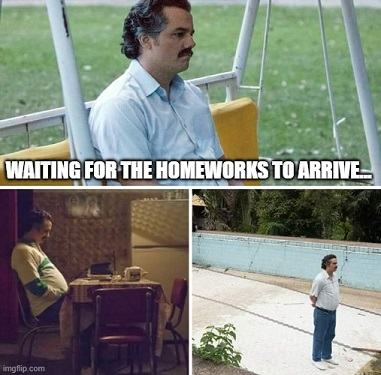